In [1]:
!pip install pennylane
!pip install numpy
!pip install pandas
!pip install scikit-learn

In [2]:
import numpy as np
n_samples = 100
p_1 = 0.2
x_data = np.random.binomial(1, p_1, (n_samples,))
print(x_data)

[0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0]


In [3]:
frequency_of_zeros, frequency_of_ones = 0, 0
for x in x_data:
    if x:
        frequency_of_ones += 1/n_samples
    else:
        frequency_of_zeros += 1/n_samples
print(frequency_of_ones+frequency_of_zeros)

1.0000000000000004


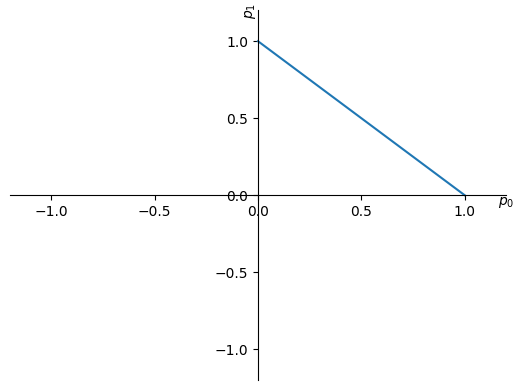

In [4]:
!pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
p_0 = np.linspace(0, 1, 100)
p_1 = 1-p_0
fig, ax = plt.subplots()
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xlabel("$p_0$")
ax.xaxis.set_label_coords(1.0, 0.5)
ax.set_ylabel("$p_1$")
ax.yaxis.set_label_coords(0.5, 1.0)
plt.plot(p_0, p_1)

In [5]:
p = np.array([[0.8], [0.2]])
np.linalg.norm(p, ord=1)

1.0

In [6]:
Π_0 = np.array([[1, 0], [0, 0]])
np.linalg.norm(Π_0 @ p, ord=1)

0.8

In [7]:
Π_1 = np.array([[0, 0], [0, 1]])
np.linalg.norm(Π_1 @ p, ord=1)

0.2

In [8]:
p = np.array([[.5], [.5]])
M = np.array([[0.7, 0.6], [0.3, 0.4]])
np.linalg.norm(M @ p, ord=1)

0.9999999999999999

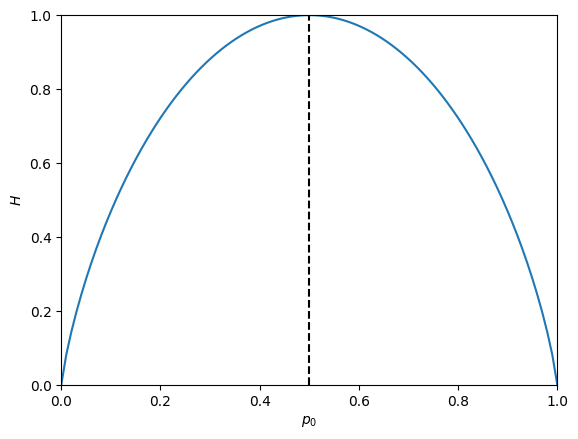

In [9]:
ϵ = 10e-10
p_0 = np.linspace(ϵ, 1-ϵ, 100)
p_1 = 1-p_0
H = -(p_0*np.log2(p_0) + p_1*np.log2(p_1))
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, -np.log2(0.5))
ax.set_xlabel("$p_0$")
ax.set_ylabel("$H$")
plt.plot(p_0, H)
plt.axvline(x=0.5, color='k', linestyle='--')

In [10]:
!pip install qiskit

Multiple qubits, entanglement and Deep Neural Network

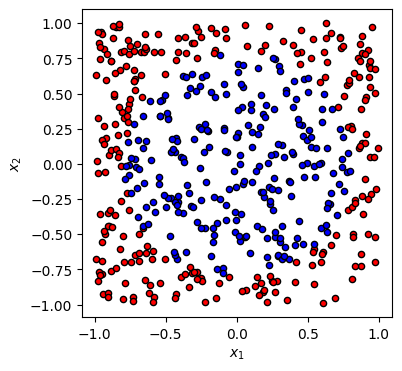

In [13]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt


# Set a random seed
np.random.seed(42)


# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


Xdata, ydata = circle(500)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

Simple classifier with data reloading and fidelity loss

In [14]:
dev = qml.device("default.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)


Utility functions for testing and creating batches

In [19]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

Train a quantum classifier on the circle dataset

In [20]:
# Generate training and test data
num_training = 200
num_test = 2000

Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.474311 | Train accuracy: 0.370000 | Test Accuracy: 0.381000
Epoch:  1 | Loss: 0.273109 | Train accuracy: 0.565000 | Test accuracy: 0.573000
Epoch:  2 | Loss: 0.230232 | Train accuracy: 0.620000 | Test accuracy: 0.630500
Epoch:  3 | Loss: 0.219010 | Train accuracy: 0.710000 | Test accuracy: 0.710500
Epoch:  4 | Loss: 0.203602 | Train accuracy: 0.640000 | Test accuracy: 0.632500
Epoch:  5 | Loss: 0.209738 | Train accuracy: 0.680000 | Test accuracy: 0.656500
Epoch:  6 | Loss: 0.221416 | Train accuracy: 0.635000 | Test accuracy: 0.648000
Epoch:  7 | Loss: 0.193496 | Train accuracy: 0.715000 | Test accuracy: 0.713000
Epoch:  8 | Loss: 0.240845 | Train accuracy: 0.640000 | Test accuracy: 0.690000
Epoch:  9 | Loss: 0.216311 | Train accuracy: 0.735000 | Test accuracy: 0.718000
Epoch: 10 | Loss: 0.192563 | Train accuracy: 0.725000 | Test accuracy: 0.745000


In [ ]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()